# Use Case: Enhanced Contract and Supply Chain Management for International Shipping


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/third_party/gravity9/Agentic_System_Enhanced_Contract_and_Supply_Chain_Management_for_International_Shipping.ipynb)

[![Watch the Webinar](https://img.shields.io/badge/Watch%20the%20Webinar-Click%20Here-blue)](https://www.mongodb.com/events/webinar/building-advanced-gen-ai-apps-with-gravity9-and-mongodb)

**Objective:** Streamline operations, improve customer service, and optimize supply chain management for a shipping company through an AI-driven agent that uses Retrieval-Augmented Generation (RAG) architecture, MongoDB Atlas, and Large Language Models (LLMs).

## Solution Overview
In international shipping, contracts are highly detailed, covering clauses for tariffs, insurance, timelines, and penalties. Supply chain operations add another layer of complexity, with inventory management, route optimization, and partner collaboration essential to efficient delivery. Departments across the company—operations, customer service, legal, and supply chain—need quick access to accurate information.

TODO: Place image of solution here

## AI Agent Solution
Leveraging RAG architecture, MongoDB Atlas, and LLMs, the proposed AI agent enables users to query both contract and supply chain data in natural language. This agent would:

1. **Retrieve Relevant Contract and Supply Chain Data:** MongoDB Atlas stores complex contract documents, shipment details, inventory levels, routing data, and supplier agreements. The RAG architecture allows the agent to retrieve relevant information based on user queries, even across multiple databases if needed.
  
2. **Generate Natural Language Responses:** The LLM synthesizes and presents the retrieved information in a clear, user-friendly way, so non-technical employees can get precise answers quickly.

### Use Case Examples
- **Operational Efficiency:** An operations manager could ask, "What penalties apply if shipment delays impact our Asia-Europe supply route?" The agent retrieves contract clauses and relevant shipping timelines to provide a direct answer.
  
- **Customer Service:** A representative could inquire, "What are the customs requirements for electronics shipped to Canada?" The agent quickly identifies key contract clauses to ensure accurate, compliant responses.
  
- **Supply Chain Optimization:** A supply chain manager could ask, "What inventory do we have in transit to Europe, and are there any delays?" The agent accesses real-time shipment and inventory data to provide a summary of items en route and any expected disruptions.
  
- **Supplier Collaboration:** If a manager asks, "What are the penalties if our supplier delays the shipment?" the agent pulls clauses from the supplier contracts and any penalties that may affect downstream partners or delivery timelines.

- **Shipment Status Update**: An operations coordinator could instruct, "Update the status of Shipment SHP-2024-001 to 'Delayed' and notify relevant stakeholders." The agent records the status change in the database, notifies impacted teams, and logs the delay along with any penalties or updated timelines, ensuring that all parties have real-time visibility of the shipment status and potential impacts.








## Benefits for Supply Chain Operations
**Efficency and Productivity Gains**

This solution minimizes the time and effort involved in searching through contracts, shipment records, and inventory databases. With natural language querying, supply chain managers, operations staff, and other departments can access critical information quickly, leading to faster decision-making, optimized routes, timely inventory management, and improved overall service quality.


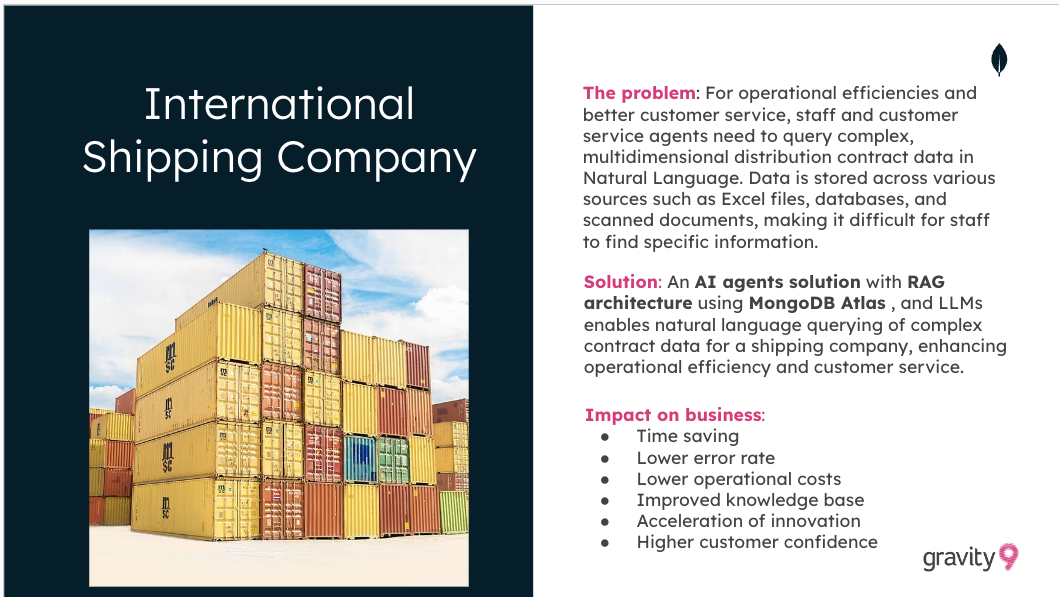

# Part 1: Semantic Search and RAG Implementation

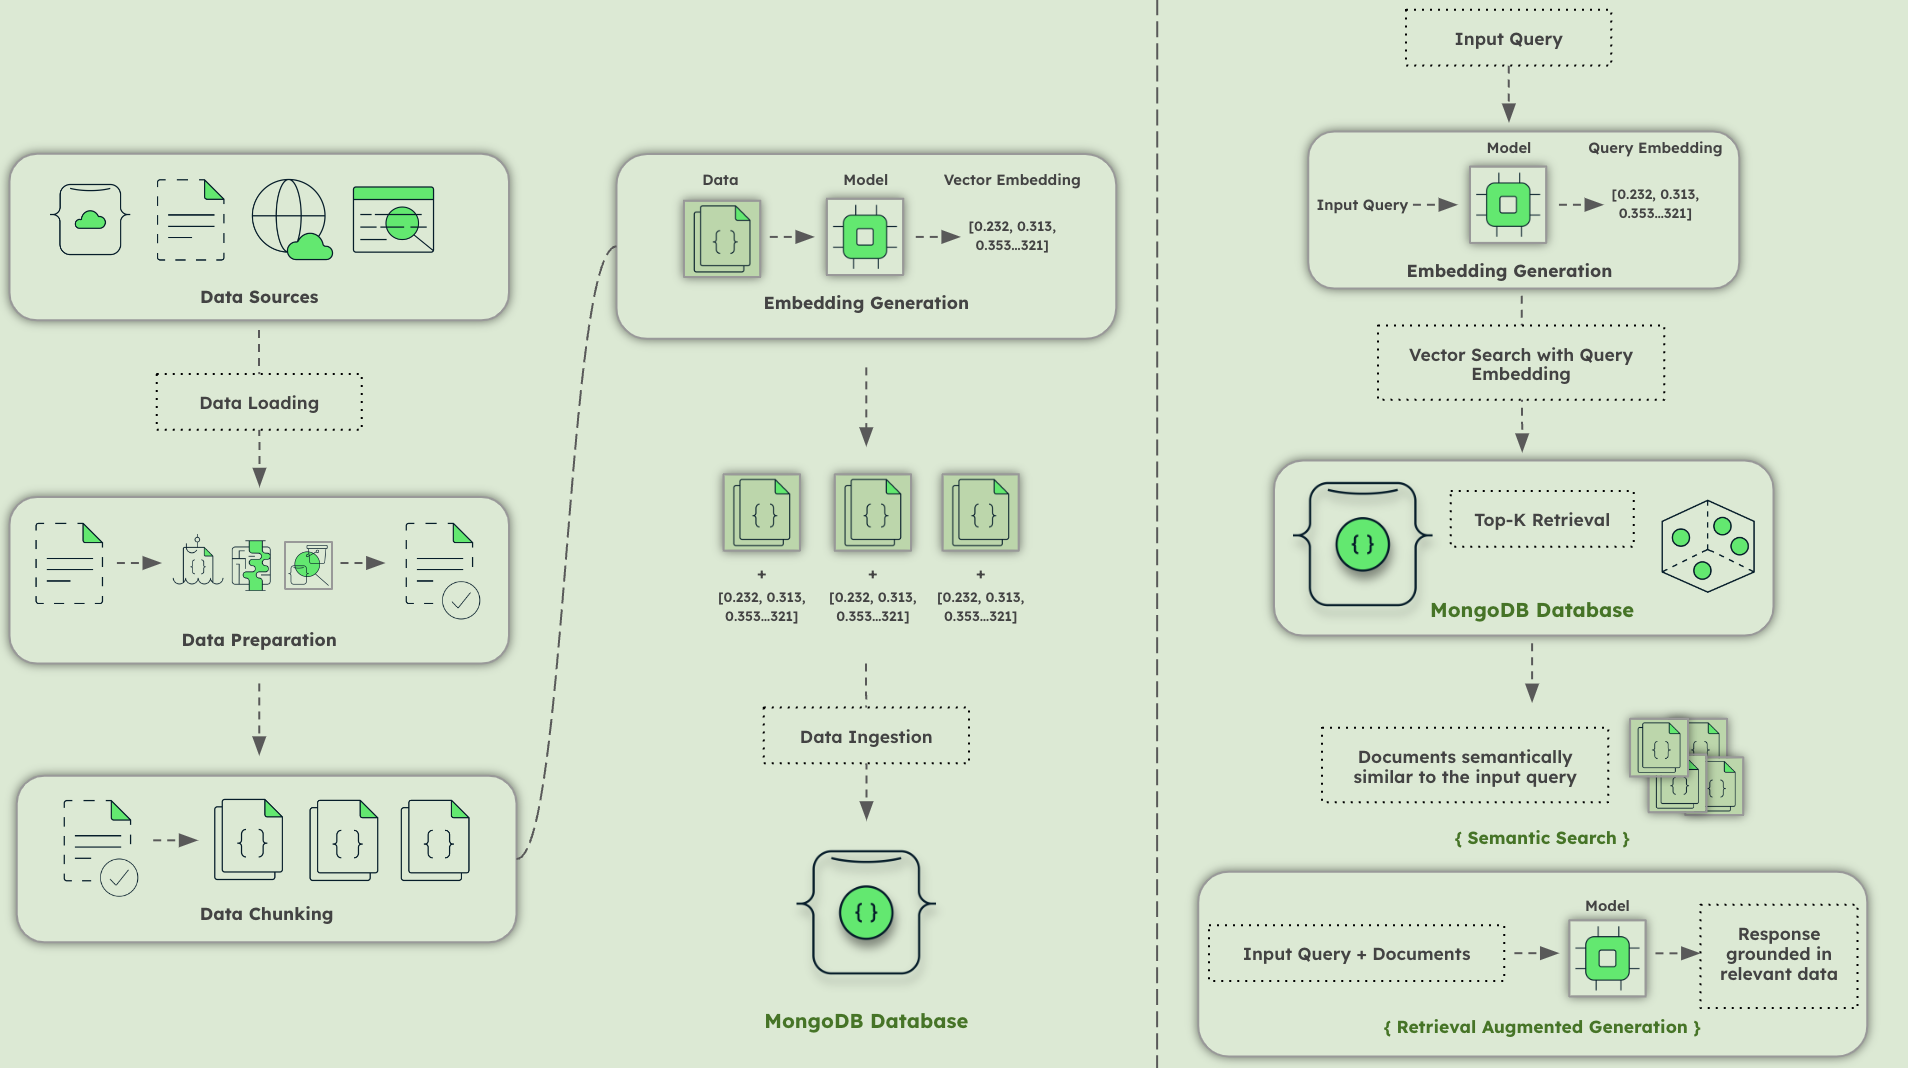

## Install Libaries and Set Environment Variables

In [3]:
!pip install --quiet -U datasets pandas pymongo pydantic anthropic voyageai tqdm

In [2]:
import os
import getpass


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

## Step 1: Data Loading (L)

In [4]:
import pandas as pd
from datasets import load_dataset

# Make sure you have an HF_TOKEN in your environment varibales to access dataset on hugging face
dataset = load_dataset("MongoDB/supply_chain_contracts_dataset_small")
shipping_contracts_dataset_df = pd.DataFrame(dataset["train"])

# Display the first few rows of the dataset
shipping_contracts_dataset_df.head()

,Contract Number,Effective Date,Shipper,Receiver,Goods Description,Quantity,Total Weight,Value,Shipping Method,Origin,...,Liability,Penalty for Late Delivery,Grace Period,Customs and Compliance,Termination Notice,Jurisdiction,Arbitration Location,Keywords,Inventory Status,Current Transit Status
0,SHP-2024-0001,2024-05-29,Montgomery Ltd,"Harvey, Collins and Gray",Machinery,2954 units,1854 kg,$256296 USD,Ocean Freight,"Port of Rotterdam, Netherlands",...,"Loss, damage, or theft up to insured value",$6917 per week of delay,7 days,Handled by receiver,60 days,China,"Dubai, UAE",time-sensitive delivery,In Transit,Delayed
1,SHP-2024-0002,2024-09-14,Contreras-Torres,Smith-Zuniga,Clothing,4698 units,5865 kg,$581163 USD,Rail Freight,"Port of New York, USA",...,Loss during transit only,$8706 per week of delay,7 days,Shipper responsible for US customs; receiver f...,45 days,Brazil,"Shanghai, China",urgent shipment,Awaiting Customs Clearance,Delayed
2,SHP-2024-0003,2024-03-03,"Sanders, Schwartz and Lopez","Gonzales, Mayo and Jackson",Electronics,3055 units,4179 kg,$245086 USD,Air Freight,"Port of Melbourne, Australia",...,"Damage liability only, no theft coverage",$1002 per week of delay,7 days,Handled by receiver,60 days,Germany,"New York, NY",textiles and fabrics,Delivered,Delayed
3,SHP-2024-0004,2024-03-25,Daniels-Long,Garrett Inc,Toys,4424 units,9653 kg,$806454 USD,Air Freight,"Port of Los Angeles, USA",...,Loss or damage up to insured value,$5399 per week of delay,7 days,Joint responsibility,Immediate for breach,Brazil,"Tokyo, Japan",perishable goods,Awaiting Customs Clearance,Delayed
4,SHP-2024-0005,2024-02-19,Adams Group,"Wallace, Finley and Ramirez",Automotive Parts,4240 units,2491 kg,$545078 USD,Road Freight,"Port of Santos, Brazil",...,Loss during transit only,$7478 per week of delay,7 days,Shipper responsible for US customs; receiver f...,15 days with mutual consent,Brazil,"London, UK",perishable goods,Awaiting Customs Clearance,On Schedule


## Step 2: Embedding Generation (L)

In [5]:
# Set VoyageAI API Key
set_env_securely("VOYAGE_API_KEY", "Enter your VoyageAI API key: ")

Enter your VoyageAI API key: ··········


In [6]:
# Set Voyage variables
VOYAGEAI_EMBEDDING_MODEL = "voyage-finance-2"
VOYAGEAI_EMBEDDING_MODEL_DIMENSION = 1024

In [7]:
import voyageai
from typing import Optional

# Initialize the voyageai client
vo = voyageai.Client()


def get_embedding(text, input_type="document") -> Optional[list[float]]:
    """Generate an embedding for the given text using VoyageAI's API."""

    # Check for valid input
    if not text or not isinstance(text, str):
        return None

    try:
        # Call voyageai to get the embedding
        result = vo.embed([text], model=VOYAGEAI_EMBEDDING_MODEL, input_type=input_type)
        embedding = result.embeddings[0]
        return embedding
    except Exception as e:
        print(f"Error in get_embedding: {e}")
        return None

In [8]:
# Concatenate fields to create a combined text representation for each data point
fields_to_concatenate = [
    "Shipper",
    "Receiver",
    "Goods Description",
    "Shipping Method",
    "Origin",
    "Destination",
    "Liability",
    "Customs and Compliance",
]

shipping_contracts_dataset_df["combined_text"] = shipping_contracts_dataset_df[
    fields_to_concatenate
].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [9]:
from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()

# Generate embeddings for each data point using the get_embeddings function and combined_text attribute
shipping_contracts_dataset_df["embedding"] = shipping_contracts_dataset_df[
    "combined_text"
].progress_apply(get_embedding)

100%|██████████| 200/200 [00:54<00:00,  3.68it/s]


In [10]:
# Delete combined_text column after generating embeddings
del shipping_contracts_dataset_df["combined_text"]

In [11]:
shipping_contracts_dataset_df.head()

,Contract Number,Effective Date,Shipper,Receiver,Goods Description,Quantity,Total Weight,Value,Shipping Method,Origin,...,Penalty for Late Delivery,Grace Period,Customs and Compliance,Termination Notice,Jurisdiction,Arbitration Location,Keywords,Inventory Status,Current Transit Status,embedding
0,SHP-2024-0001,2024-05-29,Montgomery Ltd,"Harvey, Collins and Gray",Machinery,2954 units,1854 kg,$256296 USD,Ocean Freight,"Port of Rotterdam, Netherlands",...,$6917 per week of delay,7 days,Handled by receiver,60 days,China,"Dubai, UAE",time-sensitive delivery,In Transit,Delayed,"[0.02305029332637787, -0.0150065328925848, 0.0..."
1,SHP-2024-0002,2024-09-14,Contreras-Torres,Smith-Zuniga,Clothing,4698 units,5865 kg,$581163 USD,Rail Freight,"Port of New York, USA",...,$8706 per week of delay,7 days,Shipper responsible for US customs; receiver f...,45 days,Brazil,"Shanghai, China",urgent shipment,Awaiting Customs Clearance,Delayed,"[-0.025756195187568665, 0.018554432317614555, ..."
2,SHP-2024-0003,2024-03-03,"Sanders, Schwartz and Lopez","Gonzales, Mayo and Jackson",Electronics,3055 units,4179 kg,$245086 USD,Air Freight,"Port of Melbourne, Australia",...,$1002 per week of delay,7 days,Handled by receiver,60 days,Germany,"New York, NY",textiles and fabrics,Delivered,Delayed,"[0.004681046586483717, 0.005564748775213957, 0..."
3,SHP-2024-0004,2024-03-25,Daniels-Long,Garrett Inc,Toys,4424 units,9653 kg,$806454 USD,Air Freight,"Port of Los Angeles, USA",...,$5399 per week of delay,7 days,Joint responsibility,Immediate for breach,Brazil,"Tokyo, Japan",perishable goods,Awaiting Customs Clearance,Delayed,"[0.013374928385019302, 0.013732530176639557, 0..."
4,SHP-2024-0005,2024-02-19,Adams Group,"Wallace, Finley and Ramirez",Automotive Parts,4240 units,2491 kg,$545078 USD,Road Freight,"Port of Santos, Brazil",...,$7478 per week of delay,7 days,Shipper responsible for US customs; receiver f...,15 days with mutual consent,Brazil,"London, UK",perishable goods,Awaiting Customs Clearance,On Schedule,"[0.005296943709254265, 0.01835682988166809, 0...."


## Step 3: MongoDB (Operational and Vector Database) (R)

MongoDB acts as both an operational and a vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [12]:
# Set MongoDB URI
set_env_securely("MONGO_URI", "Enter your MONGO URI: ")

Enter your MONGO URI: ··········


In [13]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.rag.supply_chain.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None


MONGO_URI = os.environ["MONGO_URI"]
if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

In [14]:
mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "supply_chain"
COLLECTION_NAME = "shipping_data"

# Create or get the database
db = mongo_client[DB_NAME]

# Create or get the collections
collection = db[COLLECTION_NAME]

Connection to MongoDB successful


In [15]:
collection.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff0000000000000038'), 'opTime': {'ts': Timestamp(1731599723, 1), 't': 56}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1731599723, 1), 'signature': {'hash': b',\x9czar\x84\xaf\xb5fL\xa74\xa7\xbb\xa9r9j>\xc4', 'keyId': 7390008424139849730}}, 'operationTime': Timestamp(1731599723, 1)}, acknowledged=True)

## Step 4: Data Ingestion (R)

In [16]:
documents = shipping_contracts_dataset_df.to_dict("records")
collection.insert_many(documents)

print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


## Step 5: Vector Index Creation (R)

In [17]:
# The field containing the text embeddings on each document within the shipping_data collection
embedding_field_name = "embedding"
# MongoDB Atlas Vector Search index name
vector_search_index_name = "vector_index"

In [18]:
import time
from pymongo.operations import SearchIndexModel


def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
    """
    Setup a vector search index for a MongoDB collection and wait for 30 seconds.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition, name=index_name, type="vectorSearch"
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")

        # Sleep for 30 seconds
        print(f"Waiting for 30 seconds to allow index '{index_name}' to be created...")
        time.sleep(30)

        print(f"30-second wait completed for index '{index_name}'.")
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {str(e)}")
        return None

In [19]:
def create_vector_index_definition(dimensions):
    return {
        "fields": [
            {
                "type": "vector",
                "path": embedding_field_name,
                "numDimensions": VOYAGEAI_EMBEDDING_MODEL_DIMENSION,
                "similarity": "cosine",
            }
        ]
    }

In [20]:
DIMENSIONS = 1024
vector_index_definition = create_vector_index_definition(dimensions=DIMENSIONS)

In [21]:
setup_vector_search_index(collection, vector_index_definition, "vector_index")

Creating index 'vector_index'...
Waiting for 30 seconds to allow index 'vector_index' to be created...
30-second wait completed for index 'vector_index'.


'vector_index'

## Step 6: Vector Search Function (R)

In [22]:
def vector_search(
    user_query,
    collection,
    additional_stages=[],
    vector_search_index_name="vector_index",
):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.
    additional_stages (list): Additional aggregation stages to include in the pipeline.
    vector_search_index_name (str): The name of the vector search index.

    Returns:
    list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embedding(user_query)

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search stage
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name,  # specifies the index to use for the search
            "queryVector": query_embedding,  # the vector representing the query
            "path": embedding_field_name,  # field in the documents containing the vectors to search against
            "numCandidates": 150,  # number of candidate matches to consider
            "limit": 5,  # return top 5 matches
        }
    }

    unset_stage = {
        "$unset": "embedding"  # Exclude the 'embedding' field from the results
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "Contract Number": 1,  # Include the contract number field
            "Effective Date": 1,  # Include the effective date field
            "Shipper": 1,  # Include the shipper field
            "Receiver": 1,  # Include the receiver field
            "Goods Description": 1,  # Include the goods description field
            "Quantity": 1,  # Include the quantity field
            "Total Weight": 1,  # Include the total weight field
            "Shipping Method": 1,  # Include the shipping method field
            "Origin": 1,  # Include the origin field
            "Destination": 1,  # Include the destination field
            "Total Shipping Cost": 1,  # Include the total shipping cost field
            "Value": 1,  # Include the value field
            "Liability": 1,  # Include the liability field
            "Customs and Compliance": 1,  # Include the customs and compliance field
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            },
        }
    }

    # Define the aggregate pipeline with the vector search stage and additional stages
    pipeline = [vector_search_stage, unset_stage, project_stage] + additional_stages

    # Execute the search
    results = collection.aggregate(pipeline)
    return list(results)

## Step 7: Semantic Search (R)

In [23]:
import pprint

# query = "What were the most valuable shipments with the Port of Rotterdam, Netherlands, as the origin?"
query = "What are the customs requirements for toys shipped to Canada?"

get_knowledge = vector_search(query, collection)
pd.DataFrame(get_knowledge).head()

,Contract Number,Effective Date,Shipper,Receiver,Goods Description,Quantity,Total Weight,Value,Shipping Method,Origin,Destination,Total Shipping Cost,Liability,Customs and Compliance,score
0,SHP-2024-0169,2024-07-11,Mcintosh-Carpenter,Garcia Group,Toys,2262 units,7635 kg,$806060 USD,Road Freight,"Port of Melbourne, Australia","Port of Le Havre, France",$54969 USD,Loss during transit only,Third-party customs broker required,0.754654
1,SHP-2024-0120,2024-02-14,"Robles, Hunt and James","Serrano, Bradshaw and Garner",Toys,1588 units,783 kg,$703309 USD,Ocean Freight,"Port of Melbourne, Australia","Port of Cape Town, South Africa",$96190 USD,Loss during transit only,Third-party customs broker required,0.750465
2,SHP-2024-0147,2024-07-14,Morrow-Wilson,Thomas-Duncan,Toys,2906 units,1913 kg,$862579 USD,Air Freight,"Port of Tokyo, Japan","Port of Singapore, Singapore",$35698 USD,Full liability up to maximum contract value,Third-party customs broker required,0.746037
3,SHP-2024-0148,2024-11-08,"Santos, Jones and Shelton",French PLC,Toys,2006 units,2311 kg,$603218 USD,Air Freight,"Port of Tokyo, Japan","Port of Vancouver, Canada",$95084 USD,Loss or damage up to insured value,Handled by receiver,0.743339
4,SHP-2024-0189,2024-05-04,Lucas-Robles,"Fields, Davis and Clark",Toys,3511 units,2309 kg,$41496 USD,Air Freight,"Port of Miami, USA","Port of Le Havre, France",$27273 USD,Loss or damage up to insured value,Third-party customs broker required,0.742295


## Step 8: Retrieval Augmented Generation(RAG) (L)

In [24]:
set_env_securely("ANTHROPIC_API_KEY", "Enter your Anthropic API key: ")

Enter your Anthropic API key: ··········


In [25]:
import anthropic

client = anthropic.Client(api_key=os.environ["ANTHROPIC_API_KEY"])

In [26]:
def handle_user_query(query, collection):
    get_knowledge = vector_search(query, collection)

    search_result = ""
    for result in get_knowledge:
        search_result += (
            f"Contract Number: {result.get('Contract Number', 'N/A')}, "
            f"Effective Date: {result.get('effeEffective Datective_date', 'N/A')}, "
            f"Shipper: {result.get('Shipper', 'N/A')}, "
            f"Receiver: {result.get('Receiver', 'N/A')}, "
            f"Customs and Compliance: {result.get('Customs and Compliance', 'N/A')}, "
            f"Origin: {result.get('Origin', 'N/A')}, "
            f"Destination: {result.get('Destination', 'N/A')}, "
            f"Goods Description: {result.get('Goods Description', 'N/A')}, "
            f"Quantity: {result.get('Quantity', 'N/A')}, "
            f"Total Weight: {result.get('Total Weight', 'N/A')}, "
            f"Shipping Method: {result.get('Shipping Method', 'N/A')}, "
            f"Total Shipping Cost: {result.get('Total Shipping Cost', 'N/A')}, "
            f"Value: {result.get('Value', 'N/A')}, "
            f"Liability: {result.get('Liability', 'N/A')}, "
            f"Description: {result.get('Description', 'N/A')}, \n"
        )

    response = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=1024,
        system="You are a logistic assistant system.",
        messages=[
            {
                "role": "user",
                "content": f"Answer this user query: {query} with the following context:\n{search_result}",
            }
        ],
    )

    return (response.content[0].text), search_result

In [27]:
query = """
What are the customs requirements for toys shipped to Canada?
"""
response, search_results = handle_user_query(query, collection)

In [28]:
import pprint

print(response)

Based on the shipping contract details provided, the shipment that is relevant to the question about customs requirements for toys shipped to Canada is:

Contract Number: SHP-2024-0196
Origin: Port of Santos, Brazil
Destination: Port of Vancouver, Canada 
Goods Description: Toys
Customs and Compliance: Shipper responsible for US customs; receiver for destination customs

For this shipment to Canada, the key customs requirement is that the receiver (Aguilar, Hunt and Villanueva) is responsible for handling the customs clearance and any applicable duties and taxes when the toys arrive in Canada. 

Some general requirements for toy imports into Canada include:
- Toys must meet Canadian safety standards and labeling requirements
- Toys require a commercial invoice, cargo control document, and certificate of origin
- Duties and taxes like GST apply based on the toy's tariff classification and value
- Certain toy materials like wood or textiles may require additional permits or certificates


# Part 2: Making Things Agentic (L)

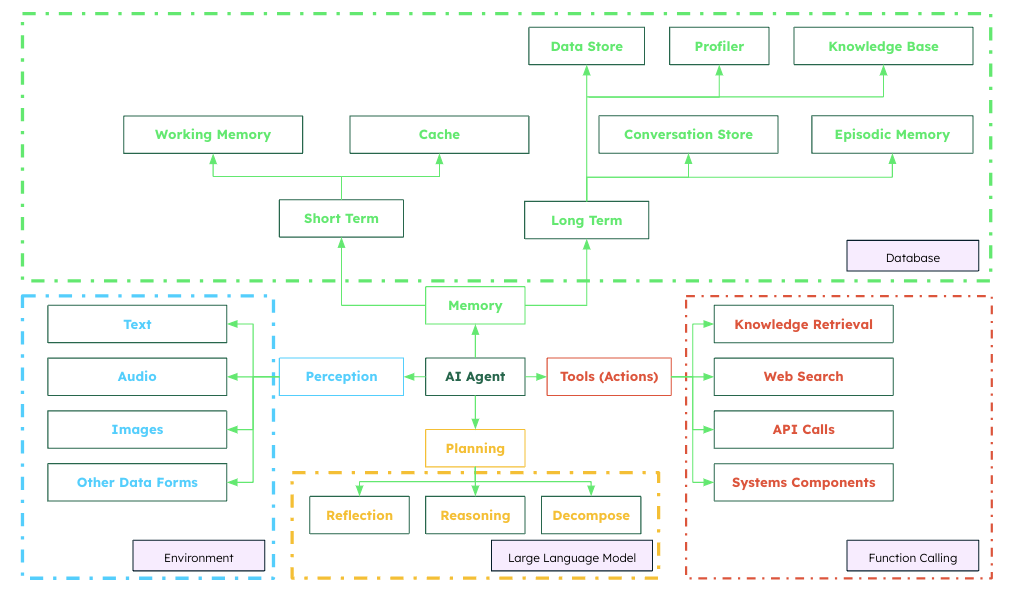

What you are building

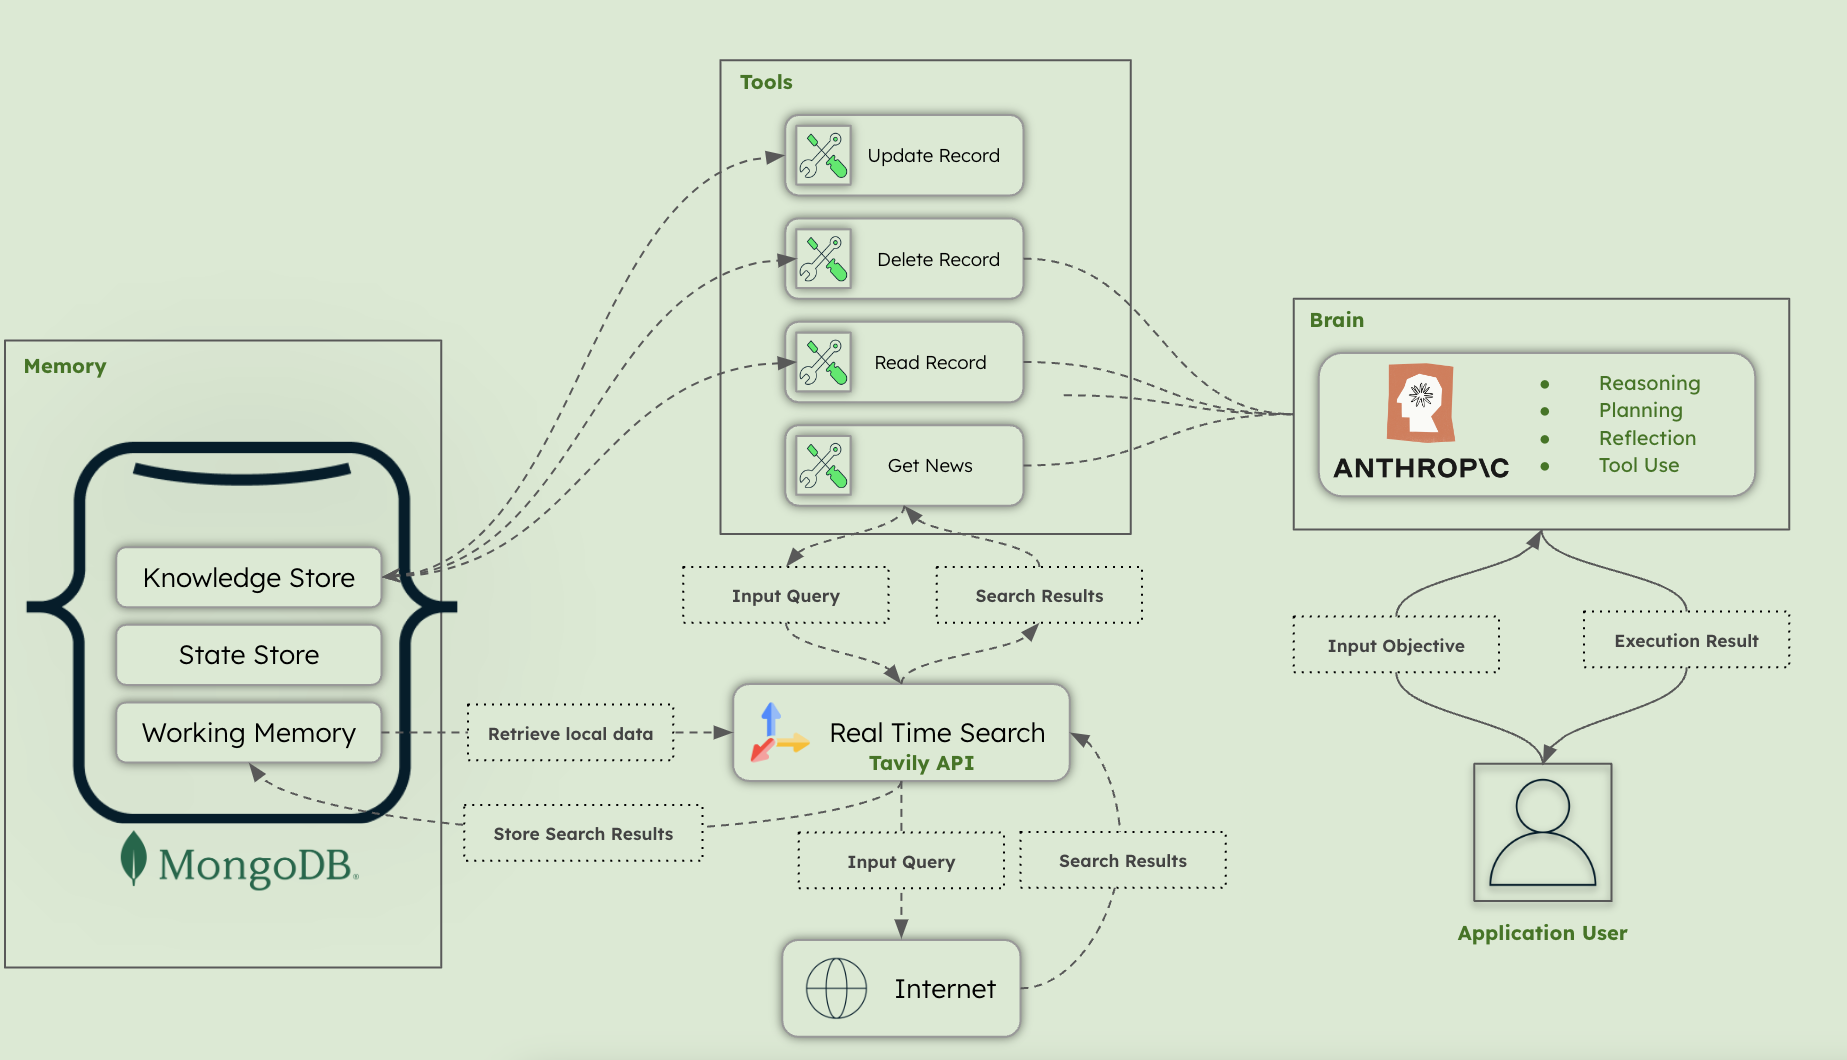

In [29]:
!pip install -U --quiet langchain-voyageai langgraph langchain_mongodb langchain langchain_anthropic motor

### Enabling LangSmith for tracing (Optional)

In [30]:
set_env_securely("LANGCHAIN_API_KEY", "Enter Langsmith API Key")

Enter Langsmith API Key··········


In [31]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "supply-chain-agentic-asssstant"

### MongoDB LangGraph Checkpointer (R)

In [32]:
import pickle
from contextlib import AbstractContextManager
from types import TracebackType
from typing import Any, Dict, Optional, AsyncIterator, Union, List, Tuple

from langchain_core.runnables import RunnableConfig
from typing_extensions import Self

from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    Checkpoint,
    CheckpointMetadata,
    CheckpointTuple,
    SerializerProtocol,
)
from langgraph.checkpoint.serde.jsonplus import JsonPlusSerializer
from motor.motor_asyncio import AsyncIOMotorClient
from datetime import datetime, timezone


class JsonPlusSerializerCompat(JsonPlusSerializer):
    def loads(self, data: bytes) -> Any:
        if data.startswith(b"\x80") and data.endswith(b"."):
            return pickle.loads(data)
        return super().loads(data)


class MongoDBSaver(AbstractContextManager, BaseCheckpointSaver):
    serde = JsonPlusSerializerCompat()

    client: AsyncIOMotorClient
    db_name: str
    collection_name: str

    def __init__(
        self,
        client: AsyncIOMotorClient,
        db_name: str,
        collection_name: str,
        *,
        serde: Optional[SerializerProtocol] = None,
    ) -> None:
        super().__init__(serde=serde)
        self.client = client
        self.db_name = db_name
        self.collection_name = collection_name
        self.collection = client[db_name][collection_name]

    def __enter__(self) -> Self:
        return self

    def __exit__(
        self,
        __exc_type: Optional[type[BaseException]],
        __exc_value: Optional[BaseException],
        __traceback: Optional[TracebackType],
    ) -> Optional[bool]:
        return True

    async def aget_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        if config["configurable"].get("thread_ts"):
            query = {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": config["configurable"]["thread_ts"],
            }
        else:
            query = {"thread_id": config["configurable"]["thread_id"]}

        doc = await self.collection.find_one(query, sort=[("thread_ts", -1)])
        if doc:
            return CheckpointTuple(
                config,
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )
        return None

    async def alist(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ) -> AsyncIterator[CheckpointTuple]:
        query = {}
        if config is not None:
            query["thread_id"] = config["configurable"]["thread_id"]
        if filter:
            for key, value in filter.items():
                query[f"metadata.{key}"] = value
        if before is not None:
            query["thread_ts"] = {"$lt": before["configurable"]["thread_ts"]}

        cursor = self.collection.find(query).sort("thread_ts", -1)
        if limit:
            cursor = cursor.limit(limit)

        async for doc in cursor:
            yield CheckpointTuple(
                {
                    "configurable": {
                        "thread_id": doc["thread_id"],
                        "thread_ts": doc["thread_ts"],
                    }
                },
                self.serde.loads(doc["checkpoint"]),
                self.serde.loads(doc["metadata"]),
                (
                    {
                        "configurable": {
                            "thread_id": doc["thread_id"],
                            "thread_ts": doc["parent_ts"],
                        }
                    }
                    if doc.get("parent_ts")
                    else None
                ),
            )

    async def aput(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
        new_versions: Optional[dict[str, Union[str, float, int]]],
    ) -> RunnableConfig:
        doc = {
            "thread_id": config["configurable"]["thread_id"],
            "thread_ts": checkpoint["id"],
            "checkpoint": self.serde.dumps(checkpoint),
            "metadata": self.serde.dumps(metadata),
        }
        if config["configurable"].get("thread_ts"):
            doc["parent_ts"] = config["configurable"]["thread_ts"]
        await self.collection.insert_one(doc)
        return {
            "configurable": {
                "thread_id": config["configurable"]["thread_id"],
                "thread_ts": checkpoint["id"],
            }
        }

    # Implement synchronous methods as well for compatibility
    def get_tuple(self, config: RunnableConfig) -> Optional[CheckpointTuple]:
        raise NotImplementedError("Use aget_tuple for asynchronous operations")

    def list(
        self,
        config: Optional[RunnableConfig],
        *,
        filter: Optional[Dict[str, Any]] = None,
        before: Optional[RunnableConfig] = None,
        limit: Optional[int] = None,
    ):
        raise NotImplementedError("Use alist for asynchronous operations")

    def put(
        self,
        config: RunnableConfig,
        checkpoint: Checkpoint,
        metadata: CheckpointMetadata,
    ) -> RunnableConfig:
        raise NotImplementedError("Use aput for asynchronous operations")

    async def aput_writes(
        self,
        config: RunnableConfig,
        writes: List[Tuple[str, Any]],
        task_id: str,
    ) -> None:
        """Asynchronously store intermediate writes linked to a checkpoint."""
        docs = []
        for channel, value in writes:
            doc = {
                "thread_id": config["configurable"]["thread_id"],
                "task_id": task_id,
                "channel": channel,
                "value": self.serde.dumps(value),
                "timestamp": datetime.now(timezone.utc).isoformat(),
            }
            docs.append(doc)

        if docs:
            await self.collection.insert_many(docs)

## Step 1: Create Tools (R)

**Let's remind ourselves of the use cases and scenarios**

1. Operational Efficiency: An operations manager could ask, "What penalties apply if shipment delays impact our Asia-Europe supply route?" The agent retrieves contract clauses and relevant shipping timelines to provide a direct answer.

2. Customer Service: A representative could inquire, "What are the customs requirements for electronics shipped to Canada?" The agent quickly identifies key contract clauses to ensure accurate, compliant responses.

3. Supply Chain Optimization: A supply chain manager could ask, "What inventory do we have in transit to Europe, and are there any delays?" The agent accesses real-time shipment and inventory data to provide a summary of items en route and any expected disruptions.

4. Supplier Collaboration: If a manager asks, "What are the penalties if our supplier delays the shipment?" the agent pulls clauses from the supplier contracts and any penalties that may affect downstream partners or delivery timelines.

5. Shipment Status Update: An operations coordinator could instruct, "Update the status of Shipment SHP-2024-001 to 'Delayed' and notify relevant stakeholders." The agent records the status change in the database, notifies impacted teams, and logs the delay along with any penalties or updated timelines, ensuring that all parties have real-time visibility of the shipment status and potential impacts.

Scenario 1, 2, 3 and 4 can be achieved with a tool that searched the collection using hybird search

Scenario 5 can be achieved with a tool that updates the status field within a document in the collection

### Create Collection Search Tool

In [33]:
# Create search index
def create_collection_search_index(collection, index_definition, index_name):
    """
    Create a search index for a MongoDB Atlas collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary defining the index mappings
    index_name: String name for the index

    Returns:
    str: Result of the index creation operation
    """

    try:
        search_index_model = SearchIndexModel(
            definition=index_definition, name=index_name
        )

        result = collection.create_search_index(model=search_index_model)
        print(f"Search index '{index_name}' created successfully")
        return result
    except Exception as e:
        print(f"Error creating search index: {str(e)}")
        return None


def print_collection_search_indexes(collection):
    """
    Print all search indexes for a given collection.

    Args:
    collection: MongoDB collection object
    """
    print(f"\nSearch indexes for collection '{collection.name}':")
    for index in collection.list_search_indexes():
        print(f"Index: {index['name']}")

In [34]:
shipping_data_text_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "Goods Description": {"type": "string"},
            "Keywords": {"type": "string"},
            "Jurisdiction": {"type": "string"},
            "Destination": {"type": "string"},
            "Origin": {"type": "string"},
            "Shipper": {"type": "string"},
            "Receiver": {"type": "string"},
        },
    }
}

In [35]:
# Create Search Index for corpus collection
TEXT_SEARCH_INDEX = "text_search_index"

create_collection_search_index(
    db[COLLECTION_NAME], shipping_data_text_index_definition, TEXT_SEARCH_INDEX
)

Search index 'text_search_index' created successfully


'text_search_index'

In [36]:
from typing import Dict, Any
from langchain.agents import tool
from langchain_voyageai import VoyageAIEmbeddings
from langchain_mongodb import MongoDBAtlasVectorSearch
from langchain_mongodb.retrievers import MongoDBAtlasHybridSearchRetriever

embedding_model = VoyageAIEmbeddings(
    voyage_api_key=os.environ["VOYAGE_API_KEY"], model=VOYAGEAI_EMBEDDING_MODEL
)

# Vector Stores Intialisation
vector_store_supply_chain_records = MongoDBAtlasVectorSearch.from_connection_string(
    connection_string=MONGO_URI,
    namespace=DB_NAME + "." + COLLECTION_NAME,
    embedding=embedding_model,
    index_name=vector_search_index_name,
    text_key="Keywords",
)

hybrid_search = MongoDBAtlasHybridSearchRetriever(
    vectorstore=vector_store_supply_chain_records,
    search_index_name=TEXT_SEARCH_INDEX,
    top_k=10,
)

In [37]:
# Let's test that hybrid search works
query = "What are the customs requirements for toys shipped to Canada?"
hybrid_search_result = hybrid_search.get_relevant_documents(query)
pprint.pprint(hybrid_search_result)

<ipython-input-37-4a0fd1527de9>:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  hybrid_search_result = hybrid_search.get_relevant_documents(query)


[Document(metadata={'_id': '67361d6f96963026f329b2fc', 'Contract Number': 'SHP-2024-0022', 'Effective Date': '2024-12-01', 'Shipper': 'Walker-Dillon', 'Receiver': 'Henry, Scott and Brown', 'Goods Description': 'Toys', 'Quantity': '421 units', 'Total Weight': '2564 kg', 'Value': '$860070 USD', 'Shipping Method': 'Air Freight', 'Origin': 'Port of Dubai, UAE', 'Destination': 'Port of Tokyo, Japan', 'Estimated Delivery Date': '2024-09-28', 'Total Shipping Cost': '$98622 USD', 'Payment Schedule': '60% upfront, 40% after 30 days of delivery', 'Insurance Coverage': 'Yes', 'Insurance Value': '$924834 USD', 'Liability': 'Loss during transit only', 'Penalty for Late Delivery': '$6336 per week of delay', 'Grace Period': '7 days', 'Customs and Compliance': 'Shipper responsible for US customs; receiver for destination customs', 'Termination Notice': '15 days with mutual consent', 'Jurisdiction': 'Germany', 'Arbitration Location': 'Dubai, UAE', 'Inventory Status': 'In Transit', 'Current Transit Stat

In [79]:
@tool
def supply_chain_hybrid_search_tool(query: str):
    """
    Perform a hybrid (vector + full-text) search on inventory, contracts, shipping items and goods.

    Args:
        query (str): The search query string.

    Returns:
        list: Relevant inventory documents from hybrid search.

    Note:
        Uses both supply_chain_hybrid_search_tool and text_search_index.
    """

    hybrid_search = MongoDBAtlasHybridSearchRetriever(
        vectorstore=vector_store_supply_chain_records,
        search_index_name=TEXT_SEARCH_INDEX,
        top_k=5,
    )

    hybrid_search_result = hybrid_search.get_relevant_documents(query)

    # Remove embedding from the result
    for result in hybrid_search_result:
        if "embedding" in result:
            del result["embedding"]

    return str(hybrid_search_result)

### Create Field Update Tool

In [80]:
@tool
def update_transit_status(input: str) -> str:
    """

    Updates the status of a shipment in transit.
    Input should be in the format: 'shipment_id,new_status'.
    For example: 'SHP-2024-001,Delayed'

    """
    try:
        shipment_id, new_status = input.split(",")
        # Update the record in MongoDB
        result = collection.update_one(
            {"Contract Number": shipment_id},
            {"$set": {"Current Transit Status": new_status}},
        )
        if result.modified_count > 0:
            return (
                f"Successfully updated status of shipment {shipment_id} to {new_status}"
            )
        else:
            return f"No shipment found with ID {shipment_id}"
    except ValueError:
        return "Invalid input format. Please use 'shipment_id,new_status'"

### Create Inventory and Transit Status Tool

1. **Inventory Status:**

This represents the current handling or processing state of the shipment within a supply chain or logistics facility. It indicates whether the shipment is physically in storage, undergoing customs checks, waiting for a clearance, or already delivered.

2. **Current Transit Status:**

This indicates the current progress or issues regarding the actual movement of the shipment between the origin and the destination.


In [81]:
@tool
def get_contracts_by_transit_status(status, limit=5):
    """
    Retrieves contract information from MongoDB based on the Current Transit Status.

    Args:
      status: The Current Transit Status to filter by (e.g., "Delayed", "On Schedule").

    Returns:
      A list of contract documents matching the specified status.
    """

    try:
        # Query the collection and project out embedding using $project
        contracts = collection.find(
            {"Current Transit Status": status},
            {
                "Contract Number": 1,
                "Goods Description": 1,
                "Origin": 1,
                "Destination": 1,
                "Shipper": 1,
                "Receiver": 1,
                "Current Transit Status": 1,
            },
        ).limit(limit)

        # Return the results
        return str(list(contracts))
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []


@tool
def get_contracts_by_inventory_status(status, limit=5):
    """
        Retrieves contract information from MongoDB based on the Inventory Status.

        Args:
            status: The Inventory Status to filter by (e.g., "Delivered", "Awaiting Customs Clearance", "
    In Transit", "Pending Dispatch").
            limit: The maximum number of contracts to retrieve (default is 5).

        Returns:
            A list of contract documents matching the specified inventory status.
    """
    try:
        # Query the collection
        contracts = collection.find(
            {"Inventory Status": status},
            {
                "Contract Number": 1,
                "Goods Description": 1,
                "Origin": 1,
                "Destination": 1,
                "Shipper": 1,
                "Receiver": 1,
                "Inventory Status": 1,
            },
        ).limit(limit)

        # Return the results
        return str(list(contracts))
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []

In [82]:
toolbox = [
    supply_chain_hybrid_search_tool,
    update_transit_status,
    get_contracts_by_transit_status,
    get_contracts_by_inventory_status,
]

### Get Real Time News On Particular Shippment (Optional)

In [83]:
!pip install --quiet tavily-python cohere

In [44]:
# Set up Tavily API Key
set_env_securely("TAVILY_API_KEY", "Enter your Tavily API Key: ")

Enter your Tavily API Key: ··········


In [45]:
# Add Cohere API Key to Environment Variable
set_env_securely("COHERE_API_KEY", "Enter your Cohere API Key: ")

Enter your Cohere API Key: ··········


In [84]:
from pymongo import MongoClient
from tavily import TavilyHybridClient

hybrid_rag = TavilyHybridClient(
    api_key=os.environ.get("TAVILY_API_KEY"),
    db_provider="mongodb",
    collection=collection,
    index=vector_search_index_name,
    embeddings_field="embedding",
    content_field="Keywords",
)


@tool
def get_real_time_news_on_shipment_by_contract(
    contract_number, max_local=5, max_foreign=2
):
    """
    Retrieves real-time news related to a specific shipment by contract number.

    Args:
      contract_number (str): The contract number to find the shipment details or information.
      max_local (int): Maximum number of local results to retrieve.
      max_foreign (int): Maximum number of foreign results to retrieve.

    Returns:
      list: A list of news results relevant to the shipment.
    """
    try:
        # Retrieve shipment details from the MongoDB collection
        shipment_details = collection.find_one({"Contract Number": contract_number})

        if not shipment_details:
            print(f"No shipment found with contract number: {contract_number}")
            return []

        # Construct a query for real-time news related to the shipment
        query = (
            f"Get real-time news about {shipment_details['Shipping Method']} disruptions, "
            f"customs issues at {shipment_details['Destination']}, port congestion at "
            f"{shipment_details['Origin']} or {shipment_details['Destination']}, "
            f"and logistics or supply chain issues related to shipping {shipment_details['Goods Description']} "
            f"from {shipment_details['Origin']} to {shipment_details['Destination']}."
        )

        print(query)

        # Use hybrid_rag to perform the search
        results = hybrid_rag.search(
            query, max_local=max_local, max_foreign=max_foreign, save_foreign=True
        )

        return results

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return []

In [85]:
# Example usage
contract_number = "SHP-2024-0002"
results = get_real_time_news_on_shipment_by_contract(contract_number)
print(results)

Get real-time news about Rail Freight disruptions, customs issues at Port of Santos, Brazil, port congestion at Port of New York, USA or Port of Santos, Brazil, and logistics or supply chain issues related to shipping Clothing from Port of New York, USA to Port of Santos, Brazil.
[{'content': 'Brazil Port Congestion: Calls: Santos: Container Ships data is updated weekly, averaging 38.000 Unit from Jan 2022 (Median) to 28 Oct 2024, with 144 observations. | Brazil Port Congestion: Calls: Ilheus: Dry Breakbulk (Unit) | 1.000 13 May 2024 | weekly | 14 Mar 2022 - 13 May 2024 | | Brazil Port Congestion: Calls: Santos: Dry Bulk (Unit) | 20.000 04 Nov 2024 | weekly | 31 Jan 2022 - 04 Nov 2024 | | Brazil Port Congestion: Calls: Vila Do Conde: Other Markets (Unit) | 3.000 04 Nov 2024 | weekly | 07 Mar 2022 - 04 Nov 2024 | | Brazil Port Congestion: Calls: Manaus: Dry Breakbulk (Unit) | 1.000 07 Oct 2024 | weekly | 07 Mar 2022 - 07 Oct 2024 |', 'score': 0.7756048, 'origin': 'local'}, {'content': '

In [86]:
toolbox.append(get_real_time_news_on_shipment_by_contract)

In [87]:
pprint.pprint(toolbox)

[StructuredTool(name='supply_chain_hybrid_search_tool', description='Perform a hybrid (vector + full-text) search on inventory, contracts, shipping items and goods.\n\nArgs:\n    query (str): The search query string.\n\nReturns:\n    list: Relevant inventory documents from hybrid search.\n\nNote:\n    Uses both supply_chain_hybrid_search_tool and text_search_index.', args_schema=<class 'langchain_core.utils.pydantic.supply_chain_hybrid_search_tool'>, func=<function supply_chain_hybrid_search_tool at 0x7912f4def760>),
 StructuredTool(name='update_transit_status', description="Updates the status of a shipment in transit.\nInput should be in the format: 'shipment_id,new_status'.\nFor example: 'SHP-2024-001,Delayed'", args_schema=<class 'langchain_core.utils.pydantic.update_transit_status'>, func=<function update_transit_status at 0x79131d4d80d0>),
 StructuredTool(name='get_contracts_by_transit_status', description='Retrieves contract information from MongoDB based on the Current Transit S

## Step 2: Define LLM (R)

In [88]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

# Do note that Anthropic LLM has a rate/token limit
# and this can affect the agentic execution
# https://docs.anthropic.com/en/api/rate-limits#rate-limits
llm = ChatAnthropic(
    model="claude-3-5-sonnet-20240620", temperature=0, max_tokens=1024, timeout=None
)

### Step 3: Define State (R)

In [65]:
from typing import Annotated, TypedDict, List
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sender: str

## Step 4: Define Agent Node (R)

In [89]:
from datetime import datetime
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_message = """
You are an AI-powered Logistics Assistant designed to streamline operations and enhance customer service for an international shipping company. You are equipped with tools to access and process contract details, shipment information, inventory data, and supply chain updates.

Your primary objectives are to:

1. Answer user queries accurately and efficiently by retrieving relevant information from the available data sources.

2. Provide support for operational tasks, including updating shipment statuses and notifying relevant stakeholders.

3. Facilitate informed decision-making by offering insights based on contract terms, shipping regulations, and supply chain dynamics.

Here are some examples of the types of queries and tasks you can handle:

Operational Efficiency:
- "What penalties apply if shipment delays impact our Asia-Europe supply route?"
- "What are the expected delivery timelines for shipments from China to the US?"

Customer Service:
- "What are the customs requirements for electronics shipped to Canada?"
- "What is the status of shipment SHP-2024-003?"

Supply Chain Optimization:
- "What inventory do we have in transit to Europe, and are there any delays?"
- "Which suppliers have the highest on-time delivery rates?"

Shipment Status Update:
- "Update the status of Shipment SHP-2024-001 to 'Delayed' and notify relevant stakeholders."
- "Log a delay for shipment SHP-2024-002 and record the reason for the delay."

Supplier Collaboration:
- "What are the penalties if our supplier delays the shipment?"
- "What are the terms of our contract with supplier XYZ regarding delivery schedules?"

Remember to:

- Always prioritize data accuracy and compliance with regulations.
- Provide clear and concise responses to user queries.
- Utilize the available tools to access and process information effectively.
- Offer helpful insights and recommendations based on your analysis.
- Maintain a professional and customer-centric approach in all interactions.
"""

base_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful AI assistant, collaborating with other assistants. "
            "Use the provided tools to progress towards answering the question. "
            "If you are unable to fully answer, that's OK, another assistant with different tools "
            "will help where you left off. Execute what you can to make progress. "
            "If you or any of the other assistants have the final answer or deliverable, "
            "prefix your response with FINAL ANSWER so the team knows to stop. "
            "\n{system_message}"
            "\nCurrent time: {time}.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

prompt = base_prompt.partial(
    system_message=system_message, time=lambda: str(datetime.now())
)

agent = prompt | llm.bind_tools(toolbox)

name = "SupplyChainAssistant"

In [90]:
from langchain_core.messages import trim_messages


def agent_node(state: AgentState, config: RunnableConfig):
    print("----Calling Agent Node-------")
    messages = state["messages"]

    result = agent.invoke(messages, config)

    if isinstance(result, ToolMessage):
        result = ToolMessage(**result.dict(exclude={"type", "name"}), name=name)
    elif isinstance(result, AIMessage):
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)

    return {
        "messages": [result],
        "sender": name,
    }

## Step 5: Define Tool Node (R)

In [91]:
import json
from typing import List, Callable
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage

tools_by_name = {tool.name: tool for tool in toolbox}


# TODO: Use AgentState Model for return value
def tool_node(state: AgentState):
    print()
    print("----Calling Tool Node-------")
    print()
    outputs = []
    tool_name = None
    for tool_call in state["messages"][-1].tool_calls:
        tool_name = tool_call["name"]
        tool_result = tools_by_name[tool_name].invoke(tool_call["args"])

        print(f"Using tool {tool_name}")
        print(f"Result: {tool_result}")
        print()

        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_name,
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outputs, "sender": tool_name}

## Step 6: Define Graph (R)

In [92]:
from langgraph.graph import END, StateGraph
from langchain_core.messages import BaseMessage


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [70]:
# Create Graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("chatbot", agent_node)
workflow.add_node("tools", tool_node)

# Set up graph structure
workflow.set_entry_point("chatbot")
workflow.add_conditional_edges(
    "chatbot", should_continue, {"continue": "tools", "end": END}
)
workflow.add_edge("tools", "chatbot")

In [93]:
from motor.motor_asyncio import AsyncIOMotorClient

# Set up MongoDB checkpointer
mongo_client = AsyncIOMotorClient(MONGO_URI)
mongodb_checkpointer = MongoDBSaver(mongo_client, DB_NAME, "state_store")

graph = workflow.compile(checkpointer=mongodb_checkpointer)

## Step 7: Graph Visualization (R)

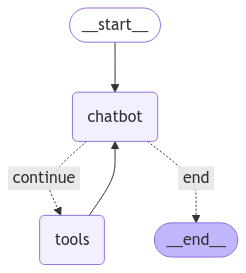

In [94]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Step 8: Graph Execution (L)

In [100]:
import asyncio
from langchain_core.messages import HumanMessage, AIMessage
import time


async def chat_loop():
    config = {"configurable": {"thread_id": "0"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(
            None, input, "User: "
        )
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        state = {"messages": [HumanMessage(content=user_input, name="Human")]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
            try:
                async for chunk in graph.astream(state, config, stream_mode="values"):
                    if "messages" in chunk and chunk["messages"]:
                        last_message = chunk["messages"][-1]
                        if isinstance(last_message, AIMessage):
                            last_message.name = last_message.name or "AI" or "AI"
                            print(last_message.content, end="", flush=True)
                    elif isinstance(last_message, ToolMessage):
                        print(f"\n[Tool Used: {last_message.name}]")
                        print(f"Tool Call ID: {last_message.tool_call_id}")
                        print(f"Content: {last_message.content}")
                        print("Assistant: ", end="", flush=True)
                break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"\nAn unexpected error occurred: {str(e)}")
                    print(f"\nRetrying in {retry_delay} seconds...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2
                else:
                    print(f"\nMax retries reached. API error: {str(e)}")
                    break

        print("\n")  # New line after the complete response

In [101]:
# For Jupyter notebooks and IPython environments
import nest_asyncio

nest_asyncio.apply()

# Run the async function
await chat_loop()

User: Hi there
Assistant: ----Calling Agent Node-------
Hello! Welcome to our AI-powered Logistics Assistant. I'm here to help you with any questions or tasks related to our international shipping operations, contract details, shipment information, inventory data, and supply chain updates. How may I assist you today? 

Is there a specific area you'd like information on, such as:
1. Checking the status of a shipment
2. Inquiring about contract details
3. Getting updates on inventory
4. Requesting information about shipping routes or customs requirements
5. Updating shipment statuses
6. Any other logistics-related query

Please let me know what you need, and I'll be happy to help!

User: what can you do?
Assistant: ----Calling Agent Node-------
Certainly! I'd be happy to explain my capabilities as an AI-powered Logistics Assistant. I'm designed to help with various aspects of international shipping and logistics. Here's an overview of what I can do:

1. Information Retrieval:
   - Search